# Classfication

## Load and setup data

In [75]:
import os
import sqlalchemy
import pandas as pd
from pathlib import Path
import numpy as np 
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
#print(os.getcwd())

In [76]:
dbEngine=sqlalchemy.create_engine('sqlite:///../../data/gdc.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_obese = "select d.*, c.*,\
  case\
   when age_at_diagnosis_years <18 then 'Under 18'\
   when age_at_diagnosis_years between 18 and 24 then '18 - 24'\
   when age_at_diagnosis_years between 25 and 34 then '25 - 34'\
   when age_at_diagnosis_years between 35 and 44 then '35 - 44'\
   when age_at_diagnosis_years between 45 and 54 then '45 - 54'\
   when age_at_diagnosis_years between 55 and 64 then '55 - 64'\
   when age_at_diagnosis_years >= 65 then '65 or older'\
 END as age_range,\
 CASE \
 	when c.\"gene.SIM1\" = '1' or c.\"gene.POMC\" = 1 or c.\"gene.LEPR\" ='1' or c.\"gene.MRAP2\" = 1 or c.\"gene.ADCY3\" = 1 or c.\"gene.NTRK2\" = 1 or c.\"gene.MC4R\"  = 1 or c.\"gene.KSR2\" = 1 or c.\"gene.LEP\" = 1 or c.\"gene.PCSK1\" = 1 or c.\"gene.BDNF\"  =1 or c.\"gene.SH2B1\" = 1 then TRUE \
 	ELSE FALSE \
 END as obesity_mutation,\
 (c.\"gene.SIM1\" + c.\"gene.POMC\" + c.\"gene.LEPR\" + c.\"gene.MRAP2\" + c.\"gene.ADCY3\" + c.\"gene.NTRK2\" + c.\"gene.MC4R\" + c.\"gene.KSR2\" + c.\"gene.LEP\" + c.\"gene.PCSK1\" + c.\"gene.BDNF\" + c.\"gene.SH2B1\") as obesity_mutation_count\
 from diagnoses d, cases c\
 where d.case_id = c.id  and year_of_diagnosis = '2011' and year_of_diagnosis is not null;"
    gdc = pd.read_sql_query(sqlstatement_obese, conn)
    gdc['year_of_diagnosis'] = gdc['year_of_diagnosis'].astype(int)
print(gdc.dtypes)
print(gdc)

case_id                    object
year_of_diagnosis           int32
age_at_diagnosis_days     float64
age_at_diagnosis_years    float64
ajcc_clinical_m            object
ajcc_clinical_t            object
ajcc_clinical_n            object
ajcc_clinical_stage        object
ajcc_pathologic_t          object
ajcc_pathologic_n          object
ajcc_pathologic_m          object
ajcc_pathologic_stage      object
id                         object
index_date                 object
primary_site               object
disease_type               object
gene.SIM1                   int64
gene.POMC                   int64
gene.LEPR                   int64
gene.MRAP2                  int64
gene.ADCY3                  int64
gene.NTRK2                  int64
gene.MC4R                   int64
gene.KSR2                   int64
gene.LEP                    int64
gene.PCSK1                  int64
gene.BDNF                   int64
gene.SH2B1                  int64
age_range                  object
obesity_mutati

In [77]:
dbEngine=sqlalchemy.create_engine('sqlite:///../../data/brfss.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_obese = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like '%aged 18 years and older who have obesity' and YearStart = 2011 order by StratificationID1;"
    brfss_obesity = pd.read_sql_query(sqlstatement_obese, conn)
    brfss_obesity['Data_Value'] = brfss_obesity['Data_Value'].astype("float")
    
print(brfss_obesity)

   YearStart  Data_Value   Age(years)
0       2011        15.2      18 - 24
1       2011        25.9      25 - 34
2       2011        29.9      35 - 44
3       2011        32.6      45 - 54
4       2011        32.6      55 - 64
5       2011        25.3  65 or older


In [78]:
dbEngine=sqlalchemy.create_engine('sqlite:///../../data/brfss.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_overweight = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like 'Percent of adults aged 18 years and older who have an overweight classification' and YearStart = 2011 order by StratificationID1;"
    brfss_overweight = pd.read_sql_query(sqlstatement_overweight, conn)
    brfss_overweight['Data_Value'] = brfss_overweight['Data_Value'].astype("float")
    
print(brfss_overweight)

   YearStart  Data_Value   Age(years)
0       2011        26.3      18 - 24
1       2011        34.0      25 - 34
2       2011        37.0      35 - 44
3       2011        37.0      45 - 54
4       2011        38.6      55 - 64
5       2011        39.5  65 or older


In [79]:
dbEngine=sqlalchemy.create_engine('sqlite:///../../data/brfss.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_nophyac = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like 'Percent of adults who engage in no leisure-time physical activity' and YearStart = 2011 order by StratificationID1;"
    brfss_nophyac = pd.read_sql_query(sqlstatement_nophyac, conn)
    brfss_nophyac['Data_Value'] = brfss_nophyac['Data_Value'].astype("float")
    
print(brfss_nophyac)

   YearStart  Data_Value   Age(years)
0       2011        16.9      18 - 24
1       2011        22.1      25 - 34
2       2011        24.3      35 - 44
3       2011        26.1      45 - 54
4       2011        28.1      55 - 64
5       2011        33.0  65 or older


In [80]:
dbEngine=sqlalchemy.create_engine('sqlite:///../../data/brfss.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_musclestr2ormore = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like 'Percent of adults who engage in muscle-strengthening activities on 2 or more days a week' and YearStart = 2011 order by StratificationID1;"
    brfss_musclestr2ormore = pd.read_sql_query(sqlstatement_musclestr2ormore, conn)
    brfss_musclestr2ormore['Data_Value'] = brfss_musclestr2ormore['Data_Value'].astype("float")
    
print(brfss_musclestr2ormore)

   YearStart  Data_Value   Age(years)
0       2011        44.1      18 - 24
1       2011        34.6      25 - 34
2       2011        29.3      35 - 44
3       2011        26.1      45 - 54
4       2011        24.0      55 - 64
5       2011        21.7  65 or older


In [81]:
brfss_gdc = gdc

def obesity_prob(age_group):
    ob_lines = brfss_obesity.loc[brfss_obesity['Age(years)'] == age_group]
    ob_line = ob_lines.iloc[0]
    return ob_line['Data_Value']

def overweight_prob(age_group):
    lines = brfss_overweight.loc[brfss_overweight['Age(years)'] == age_group]
    line = lines.iloc[0]
    return line['Data_Value']

def nophyac_prob(age_group):
    lines = brfss_nophyac.loc[brfss_nophyac['Age(years)'] == age_group]
    line = lines.iloc[0]
    return line['Data_Value']

def musclestr2ormore_prob(age_group):
    lines = brfss_musclestr2ormore.loc[brfss_musclestr2ormore['Age(years)'] == age_group]
    line = lines.iloc[0]
    return line['Data_Value']

brfss_gdc['obesity_prob'] = brfss_gdc['age_range'].map(obesity_prob)
brfss_gdc['overweight_prob'] = brfss_gdc['age_range'].map(overweight_prob)
brfss_gdc['nophyac_prob'] = brfss_gdc['age_range'].map(nophyac_prob)
brfss_gdc['musclestr2ormore_prob'] = brfss_gdc['age_range'].map(musclestr2ormore_prob)
print(brfss_gdc)

                                                case_id  year_of_diagnosis  \
0     RUNhc2U6MDA3ODFhOTYtNDA2OC00MjdjLWE5YzUtNTg0ZD...               2011   
1     RUNhc2U6NDk5NjdhNTctN2MxMi00NmJiLThkNzEtY2ViYm...               2011   
2     RUNhc2U6MDBkZGE4NjAtNTNjMy00YWIyLTgyOTQtNzNlMj...               2011   
3     RUNhc2U6NDdmMThlZWUtM2U1Ni00Mzg4LWFhYzMtOWFjMT...               2011   
4     RUNhc2U6MjNlZjIxYTAtMzY5NS00Y2EyLTk5ZTItMjc0OD...               2011   
...                                                 ...                ...   
1646  RUNhc2U6MWNhM2M1ZTAtMzJiMC00NDY3LThlYzAtY2EyMT...               2011   
1647  RUNhc2U6N2I4MmUyZDItNDdmOS00MWExLTllY2EtNDA5MD...               2011   
1648  RUNhc2U6NGIzNzA2MzktMGMwOS00ZjYwLWJiOTYtMTFjMG...               2011   
1649  RUNhc2U6NzJlNjQwZjItODY5Zi00YWVmLThlYmUtYjEyN2...               2011   
1650  RUNhc2U6ZTk4N2M0N2QtNmVjYi00MWJiLWE2NmYtYTA0OD...               2011   

      age_at_diagnosis_days  age_at_diagnosis_years ajcc_clinic

In [82]:
xdf = pd.DataFrame(brfss_gdc, columns=['age_at_diagnosis_days', 'primary_site', 'disease_type', 'obesity_prob', 'overweight_prob', 'nophyac_prob', 'musclestr2ormore_prob', 'obesity_mutation', 'obesity_mutation_count'])

#https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
def onehotEncoding(orig, feature):
    one_hot = pd.get_dummies(xdf[[feature]])
    res = pd.concat([xdf, one_hot], axis=1)
    return(res)

#xdf = onehotEncoding(xdf, 'primary_site')
# xdf = onehotEncoding(xdf, 'disease_type')
# xdf.pop('primary_site')
# xdf.pop('disease_type')
print(xdf)




      age_at_diagnosis_days                                     primary_site  \
0                   30874.0                                          Stomach   
1                   16460.0                                            Brain   
2                   21292.0                                   Prostate gland   
3                   28760.0  Connective, subcutaneous and other soft tissues   
4                   27561.0                                          Stomach   
...                     ...                                              ...   
1646                27288.0                                          Stomach   
1647                27918.0                                    Thyroid gland   
1648                 6925.0    Hematopoietic and reticuloendothelial systems   
1649                25936.0                                           Rectum   
1650                21728.0  Connective, subcutaneous and other soft tissues   

                              disease_t

(array([ 12.,  13.,   8.,  10.,   6.,   9.,  22.,  27.,  23.,  10.,  27.,
         28.,  24.,  37.,  25.,  43.,  43.,  56.,  70.,  34.,  77.,  71.,
        104., 101.,  49., 102.,  89.,  73.,  87.,  38.,  71.,  70.,  60.,
         40.,  25.,  24.,  19.,  16.,   5.,   3.]),
 array([18. , 19.8, 21.6, 23.4, 25.2, 27. , 28.8, 30.6, 32.4, 34.2, 36. ,
        37.8, 39.6, 41.4, 43.2, 45. , 46.8, 48.6, 50.4, 52.2, 54. , 55.8,
        57.6, 59.4, 61.2, 63. , 64.8, 66.6, 68.4, 70.2, 72. , 73.8, 75.6,
        77.4, 79.2, 81. , 82.8, 84.6, 86.4, 88.2, 90. ]),
 <BarContainer object of 40 artists>)

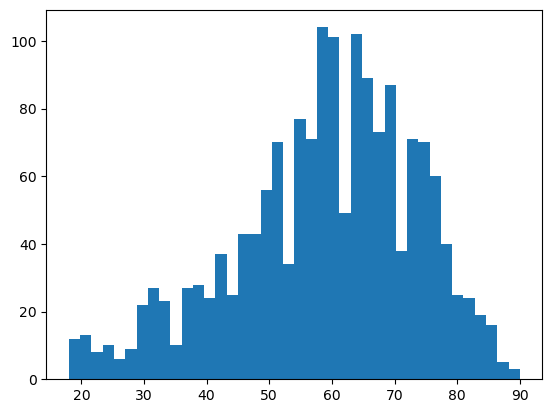

In [83]:
plt.hist(brfss_gdc['age_at_diagnosis_years'], bins=40)


c:\Users\Agnes\anaconda3\envs\MADE_PROJECT\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Agnes\anaconda3\envs\MADE_PROJECT\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


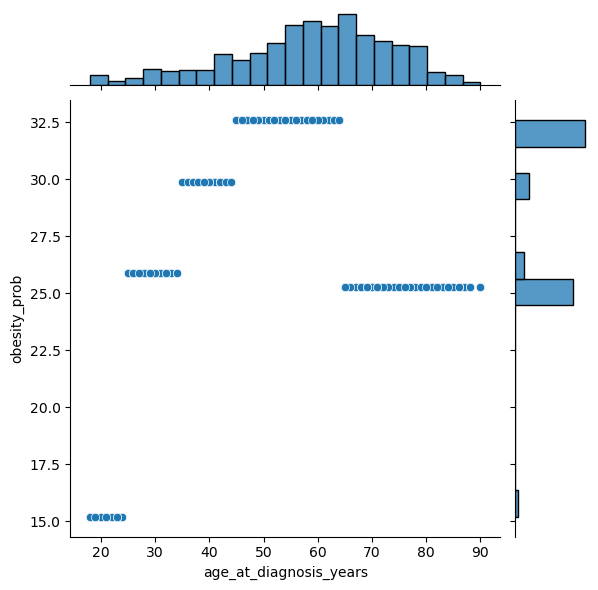

In [84]:
pd.option_context('mode.use_inf_as_na', True)
sns.jointplot(data=brfss_gdc, x='age_at_diagnosis_years', y='obesity_prob');

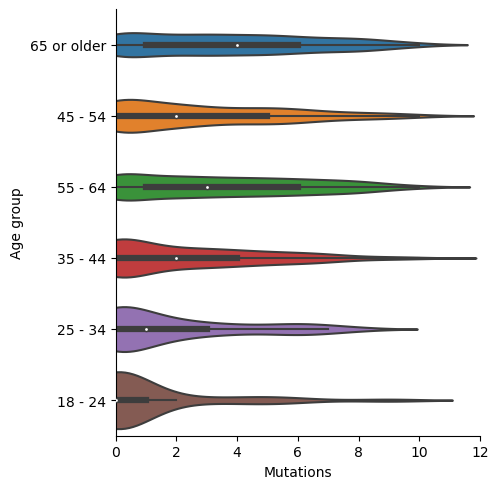

In [94]:
f=sns.catplot(data=brfss_gdc, x='obesity_mutation_count', y='age_range', kind='violin')
plt.xlabel("Mutations")
plt.ylabel("Age group")
f.set(xlim=(0,12));

c:\Users\Agnes\anaconda3\envs\MADE_PROJECT\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Agnes\anaconda3\envs\MADE_PROJECT\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Agnes\anaconda3\envs\MADE_PROJECT\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Agnes\anaconda3\envs\MADE_PROJECT\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

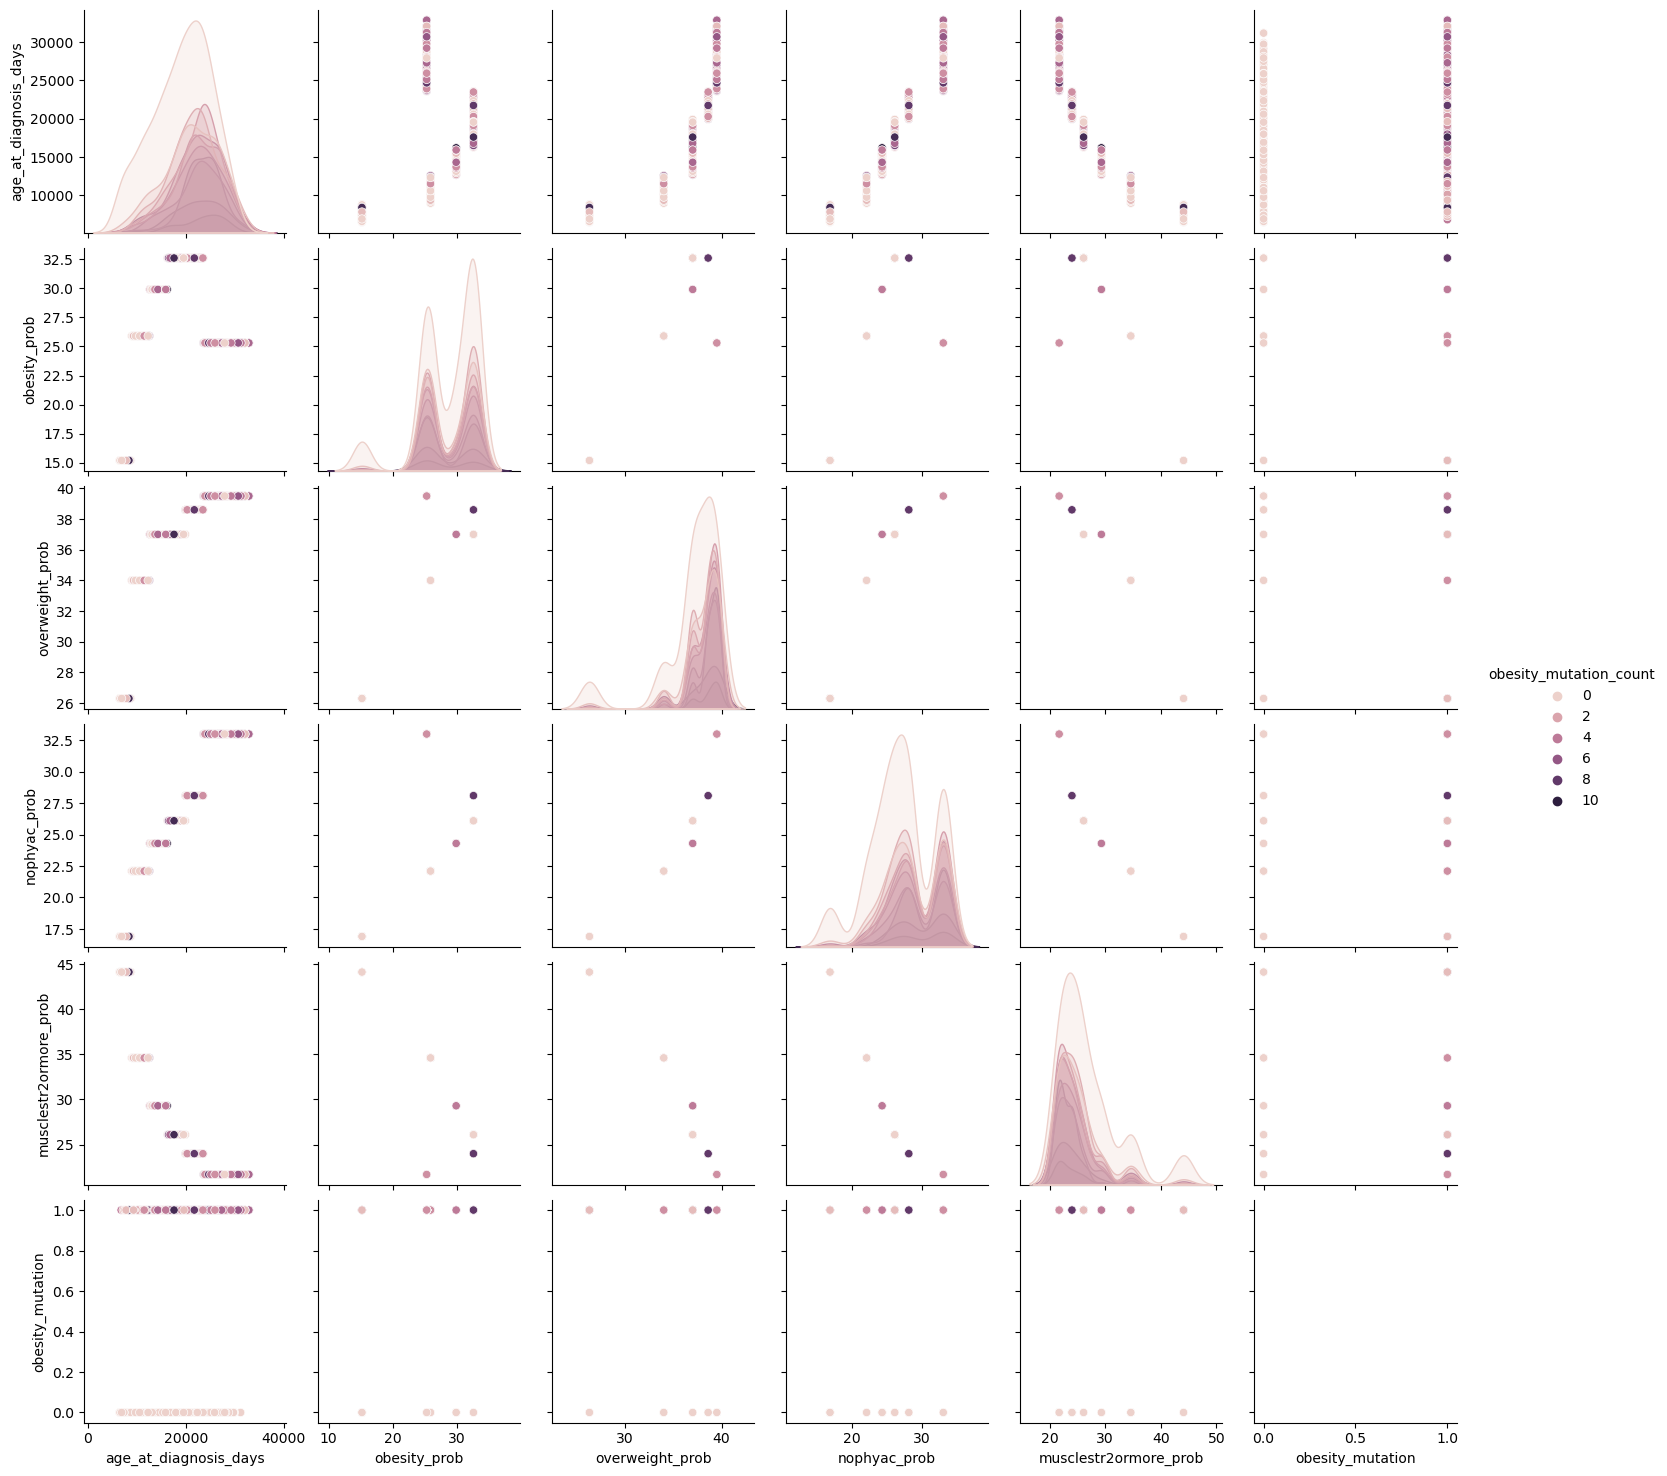

In [86]:
sns.pairplot(xdf,hue='obesity_mutation_count')

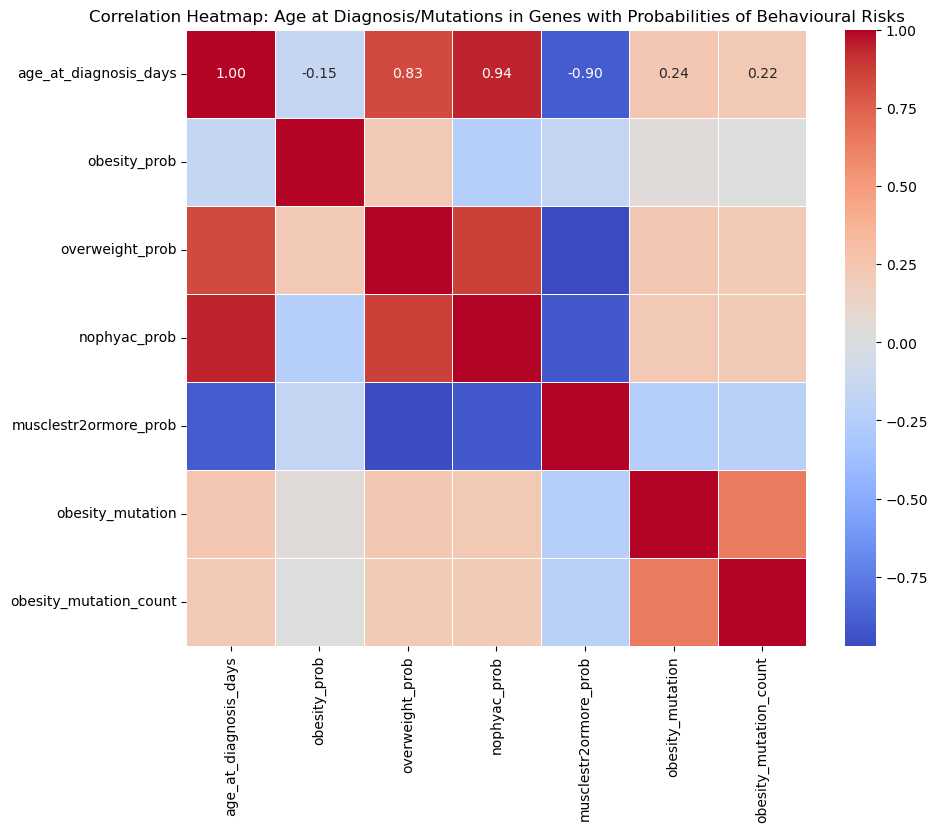

In [87]:
xdf = pd.DataFrame(brfss_gdc, columns=['age_at_diagnosis_days', 'obesity_prob', 'overweight_prob', 'nophyac_prob', 'musclestr2ormore_prob', 'obesity_mutation', 'obesity_mutation_count'])

#https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
def onehotEncoding(orig, feature):
    one_hot = pd.get_dummies(xdf[[feature]])
    res = pd.concat([xdf, one_hot], axis=1)
    return(res)

# xdf = onehotEncoding(xdf, 'primary_site')
# xdf = onehotEncoding(xdf, 'disease_type')
# xdf.pop('primary_site')
# xdf.pop('disease_type')


correlation_df = xdf
correlation_matrix = correlation_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap: Age at Diagnosis/Mutations in Genes with Probabilities of Behavioural Risks')
plt.show()